# Pump probe data
:class:`peaks` has basic capability for handling time-resolved data from pump-probe experiments. This was developed for time-resolved ARPES, but can be applied to other similar stroboscopic data.

In [1]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os
import pint_xarray

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Example data
from peaks.core.utils.sample_data import ExampleData, plot_tutorial_example_figure

## Loading data
Loading data works like usual

In [2]:
# Load some data as normal
data = ExampleData.tr_arpes()

029 Gr.zip:   0%|          | 0.00/3.61M [00:00<?, ?B/s]

Loading scans:   0%|          | 0/59 [00:00<?, ?it/s]

Now there is an additional `pump` attribute in the metadata

In [3]:
data.metadata.pump

hv: None
polarisation: None
power: None
delay: [-1000 15000] fs
t0_position: 6.007 mm

## Plotting data
The core data is returned as a single :class:`xarray.DataArray`, with a time dimension `t`, and a secondary dimension to the time dimension that encodes the actual delay line position. The data can be inspected using usual :class:`xarray` or :class:`peaks` methods. E.g. to view an interactive display, use `.disp()`:

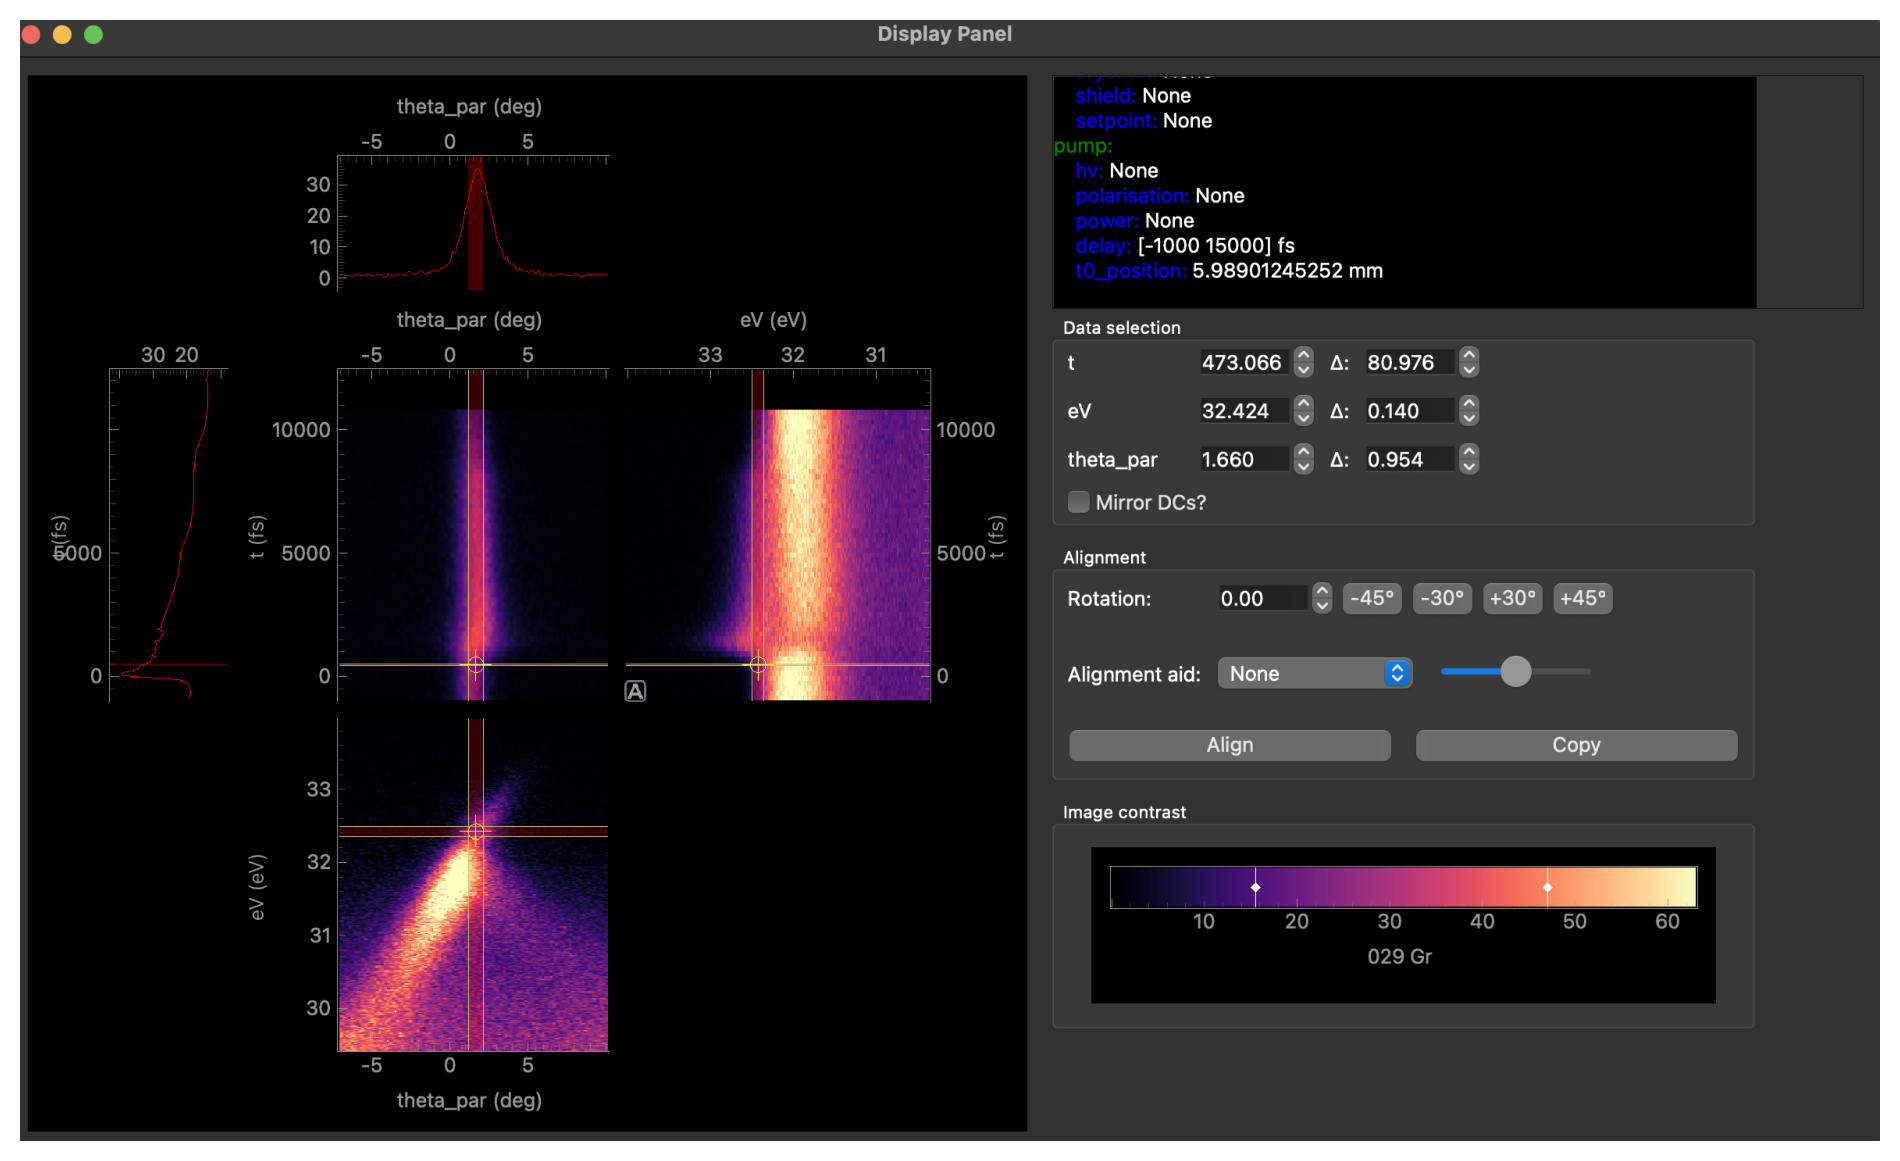

In [4]:
# Static view of the Display Panel for the documentation
plot_tutorial_example_figure("TR-ARPES_disp.png", figsize=(12,8))

Or a quick animation can be made with `.iplot()`:

In [5]:
data.iplot(y='eV', x='theta_par',
            cmap='Blues',
            widget_type='scrubber',
            widget_location='bottom',)

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=58, width=550)

Regular `peaks` selection functions work, and `pint_xarray` can be used for helpful unit conversions

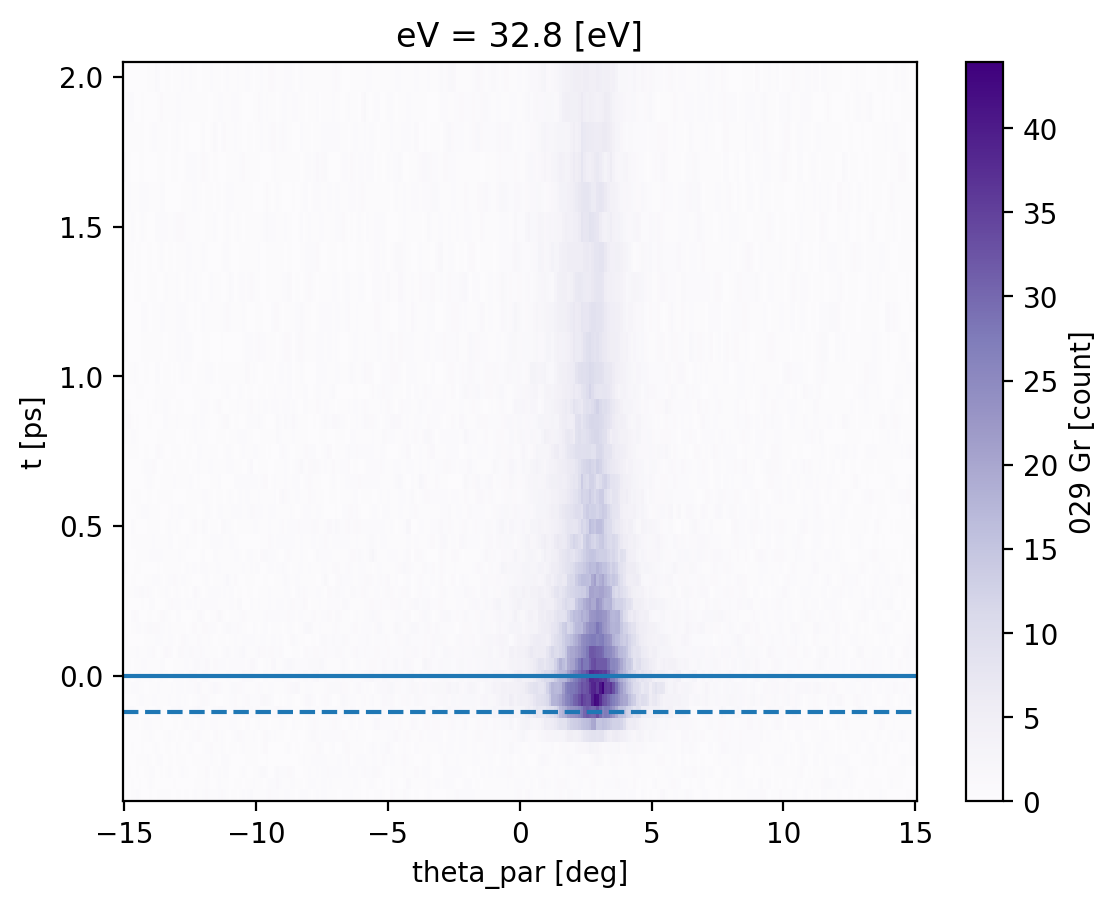

In [6]:
data.MDC(32.8,0.1).sel(t=slice(-500,2000)).pint.to({'t': 'ps'}).plot()
plt.axhline(0)  # Current t0
plt.axhline(-0.12, ls='--')  # Rough estimate of new t0

## `.tr` accessor
To access `peaks` methods for handling time-resolved data, import the `time_resolved` module. The relevant accessors can then be accessed via the `.tr` handle

In [7]:
from peaks import time_resolved

### Setting $t_0$
The helper method `.set_t0` allows setting a new $t_0$ by passing the time from the current data that should correspond to the true $t_0$. This sets a new delay line position, and recalculates the delay time dimension. 

:::{tip}
It is recommended to pass a :class:`pint.Quantity` for full handling of units. If a float is passed, it will attempt to parse the units from the base units of the $t$ dimension. Note, however, for the current :class:`xarray.DataArray` this is fs, not ps as may appear from the graph above, as that was converted to ps for the plot.
:::

In [8]:
data.metadata.pump.t0_position

<Quantity(6.007, 'millimeter')>

In [9]:
data.tr.set_t0(-120*pks.ureg('fs'))

In [10]:
data.metadata.pump.t0_position

<Quantity(5.98901245252, 'millimeter')>

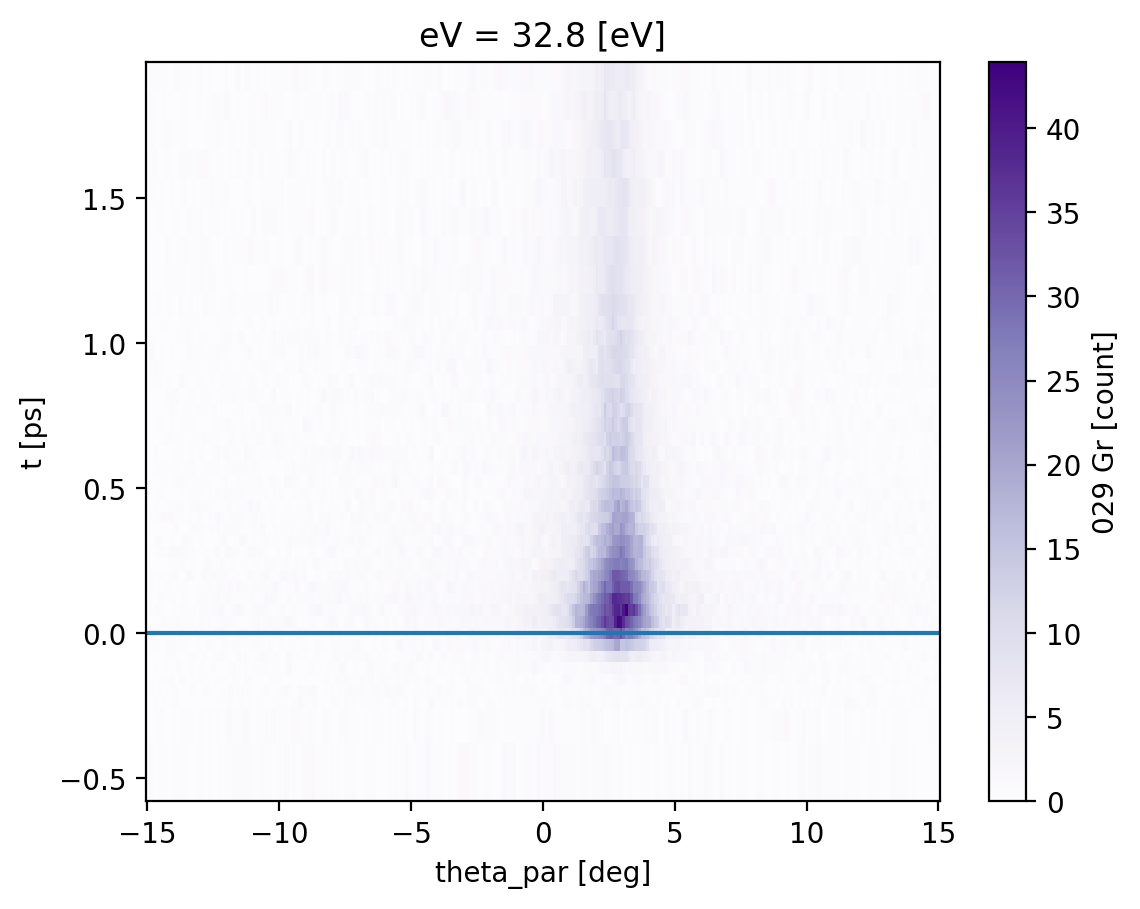

In [11]:
data.MDC(32.8,0.1).sel(t=slice(-500,2000)).pint.to({'t': 'ps'}).plot()
plt.axhline(0)  # New t0

Alternatively, to set the stage position that corresponds to $t_0$ (useful for setting this e.g. across multiple scans), you can pass a position in mm:

In [12]:
data.tr.set_t0(5.98901245252*pks.ureg('mm'))

Or you can use the `set_t0_like` method to set $t_0$ by passing another scan which has already been calibrated

In [13]:
data2 = ExampleData.tr_arpes2()
data2.tr.set_t0_like(data)

028 Gr.zip:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Loading scans:   0%|          | 0/59 [00:00<?, ?it/s]

<div class="alert alert-block alert-warning"><b>Temperature variation warning: </b> Significant temperature variation of 11.18 kelvin over the run, from 78.29 kelvin to 89.47 kelvin. Average value of 84.54 kelvin used in metadata. To view the full data, load the stats file: `from peaks.core.fileIO.loaders.clf import ArtemisPhoibos; ArtemisPhoibos.load_stats(fpath)` </div>

:::{admonition} Artemis file loader - measurement stats
:class: tip

Note the warning above regarding the temperature drift during the scan. This data was loaded using the Artemis Phiobos loader, which checks for temperature drift during the scan and provides a warning. There is a helper function built into the loader to plot the temperature variation as well as the measurement stats variation during the scan. This returns a :class:`xarray.Dataset` with the measurement statistics and temperature as variables `stats` and `temperature` respectively. 

To use this, you need to import the loader class itself:

```python
# Import the loader (see hint in the warning note)
from peaks.core.fileIO.loaders.clf import ArtemisPhoibos

# Load the stats - note you need to provide the full path; the peaks.opts settings do not work here
stats = ArtemisPhoibos.load_stats("example_artemis_stats/")

# Plot the stats
fig, ax = plt.subplots(ncols=2, figsize=(9,4))
stats.temperature.plot(ax=ax[0])
ax[0].set_title('Temperature variation')
stats.stats.plot(ax=ax[1])
ax[1].set_title('Measurement stats variation')
plt.tight_layout()
```
:::

`.assign_t0()` can be used to assign a new $t_0$ value, returning a new :class:`xarray.DataArray`, rather than updating the existing :class:`xarray.DataArray` in place.  

In [14]:
data2 = data.tr.assign_t0(-2000*pks.ureg('fs'))
print(data2.metadata.pump.t0_position == data.metadata.pump.t0_position)

False


### Selecting data
Accessor methods exist to quickly perform some common data selections:

- `.mean()`: Mean over all times
- `.static()`: Mean of data from before a certain time, which can be supplied as an option (defaults to -250 fs)
- `.diff()`: Difference between data measured at a certain delay time, or within a time window, and static data

Relevant times are again recommended to be passed with units, but will attempt to parse the current axis units if supplied as floats.

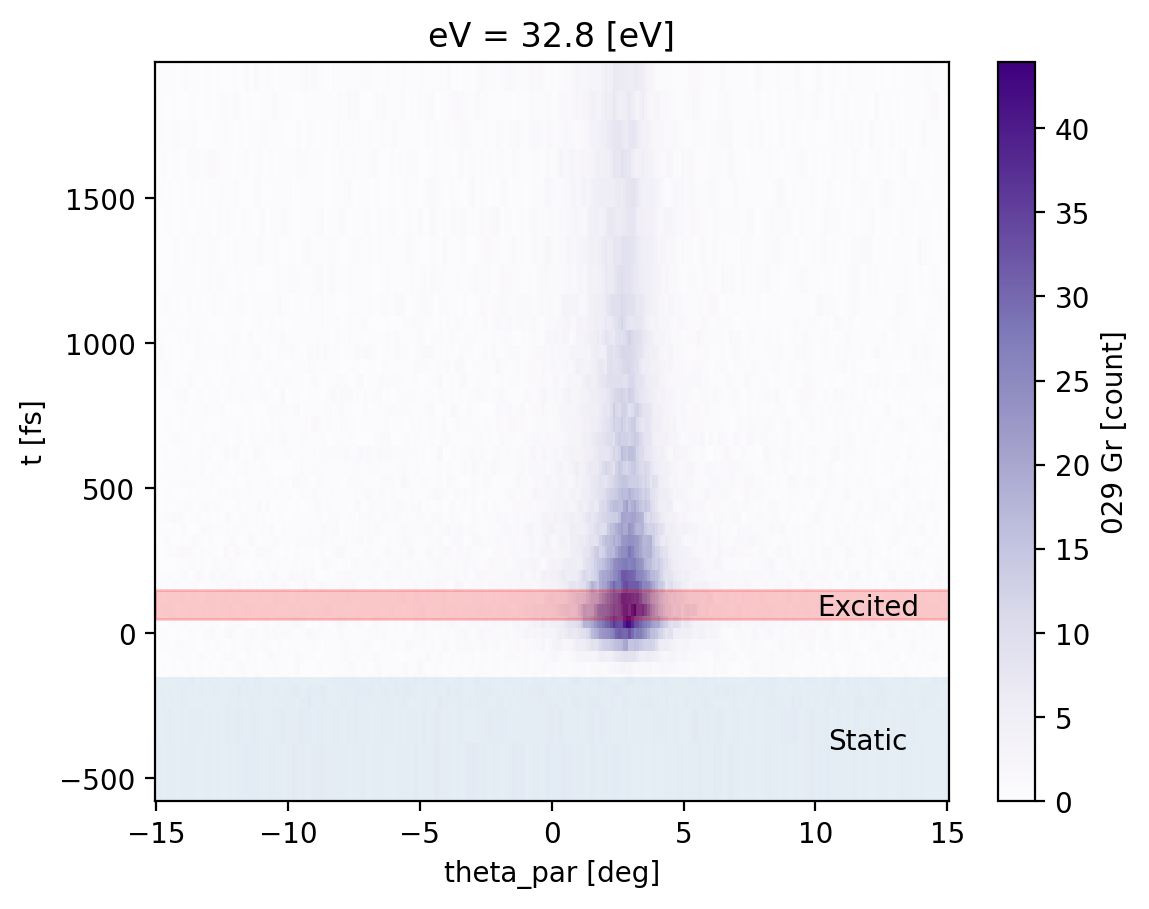

In [15]:
# Find relevant regions
data.MDC(32.8,0.1).pint.sel(t=slice(-500*pks.ureg('fs'),2000*pks.ureg.fs)).plot()
plt.axhspan(data.t.min(),-150, alpha=0.1)
plt.text(12, -400, 'Static', ha='center')
plt.axhspan(50,150, alpha=0.2, color='r')
plt.text(12, 60, 'Excited', ha='center')
plt.show()

In [16]:
mean_data = data.tr.mean()
static_data = data.tr.static(t_static=-0.15*pks.ureg('ps'))
excited_data = data.sel(t=slice(50,150)).mean('t')
diff_data = data.tr.diff(t_select=slice(0.05*pks.ureg('ps'),150*pks.ureg('fs')), t_static=-150*pks.ureg.fs)

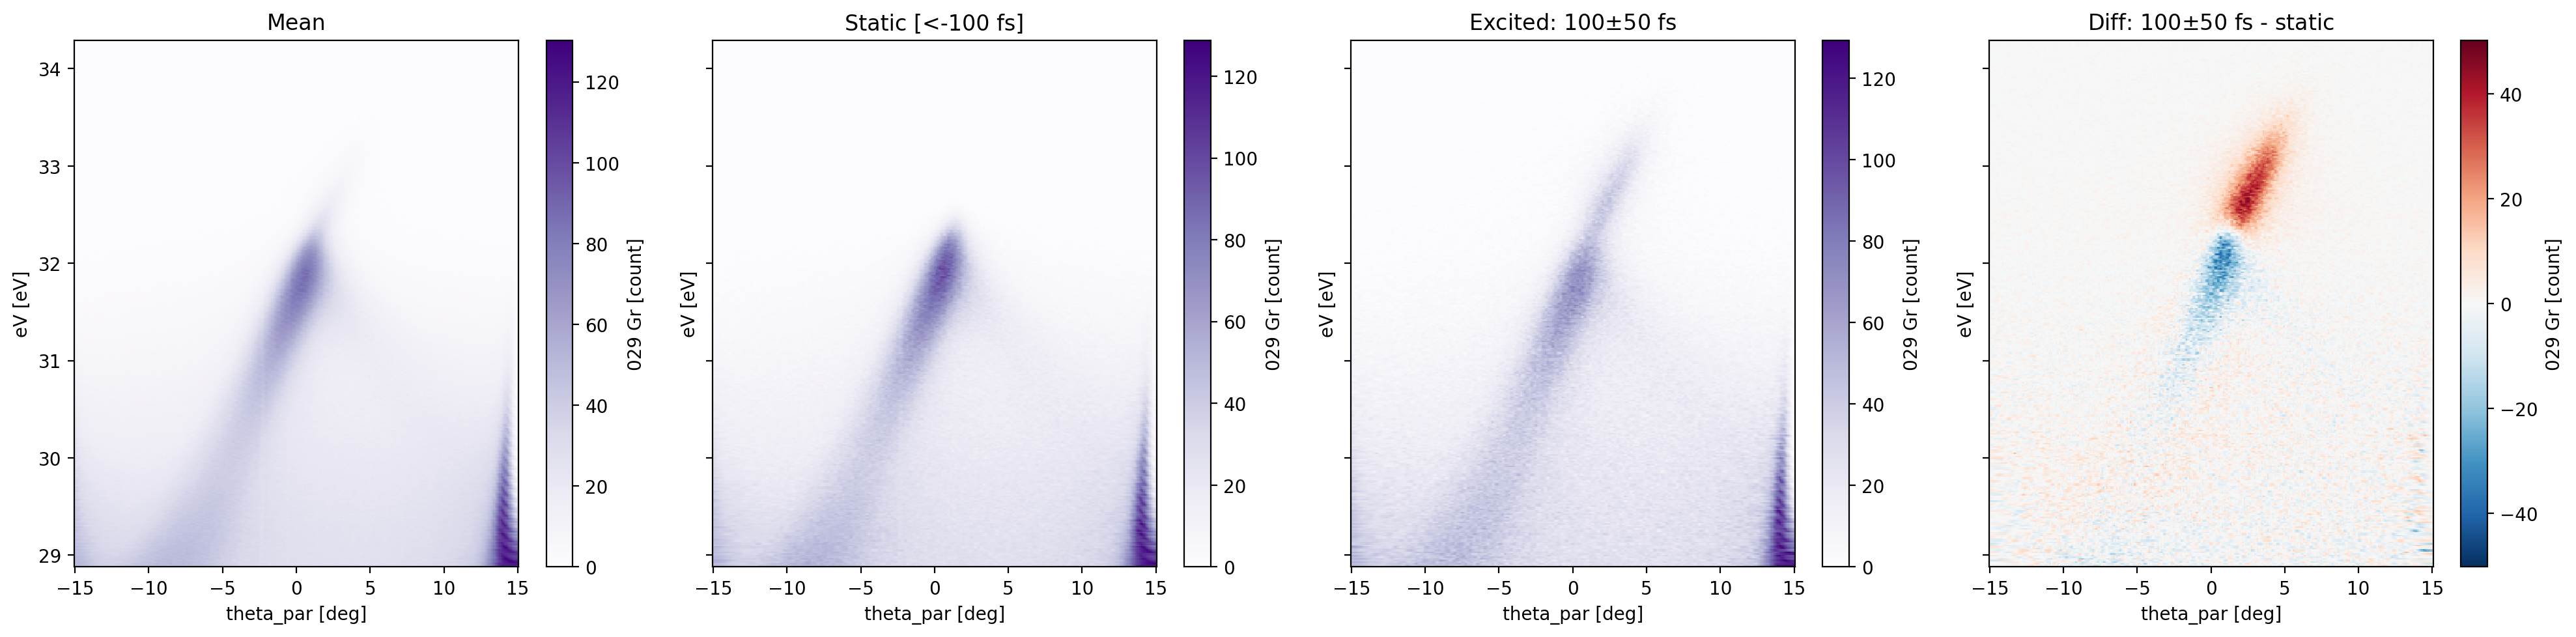

In [17]:
pks.plot_grid([mean_data, static_data, excited_data, diff_data],
              titles = ['Mean', 'Static [<-100 fs]', 'Excited: 100$\\pm$50 fs', 'Diff: 100$\\pm$50 fs - static'],
              ncols=4,
              sharey=True
             )

If calling `.diff()` with `t_select=None` (the default argument), the static spectrum is subtracted from all data in the cube

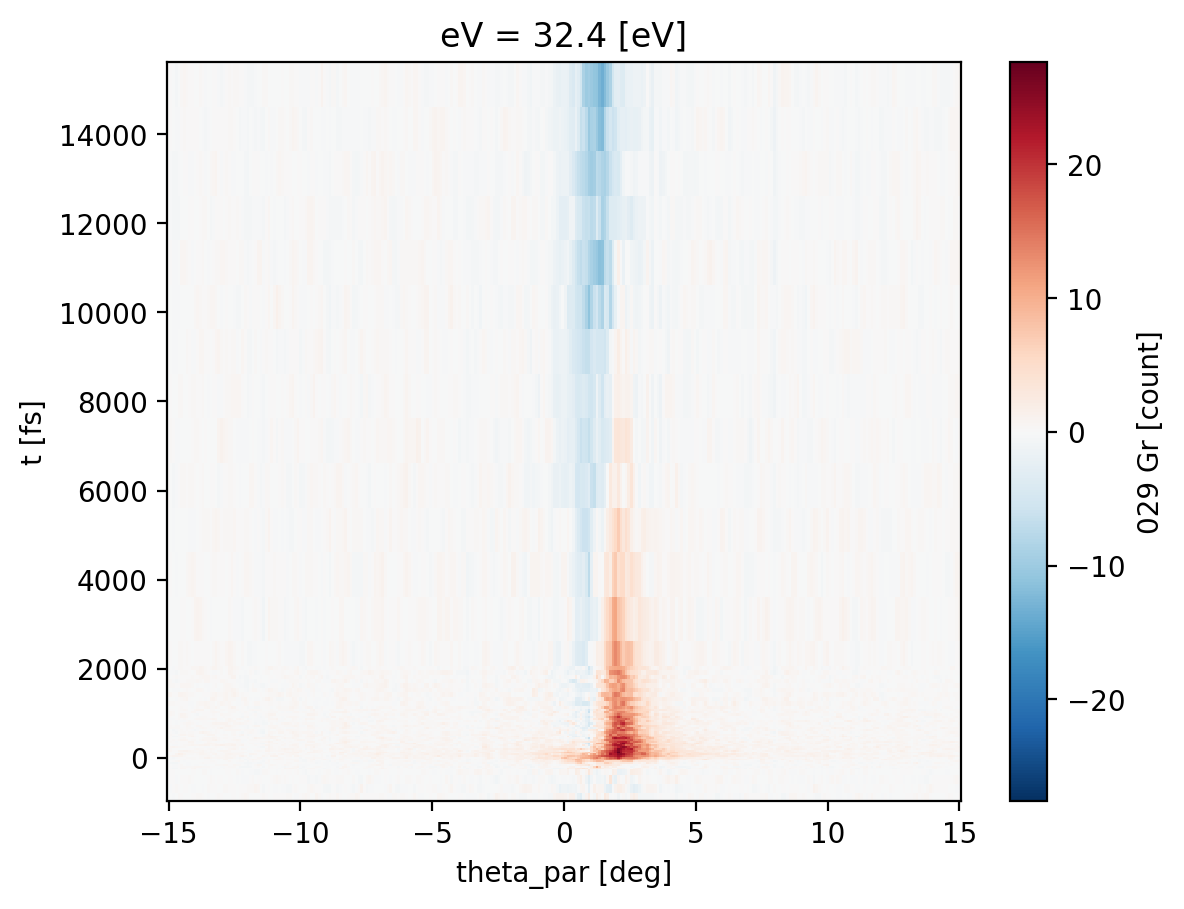

In [18]:
diff_all = data.tr.diff()
diff_all.MDC(32.4, 0.1).plot()

## Batch processing
These function, both for setting $t_0$ and for selecting from the data, can be applied to :class:`xarray.DataTree`s to faciliate batch processing.

In [19]:
dt = xr.DataTree()
dt.add(ExampleData.tr_arpes())
dt.add(ExampleData.tr_arpes2())

/Users/pdk6/miniconda3/envs/peaks-dev/lib/python3.12/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


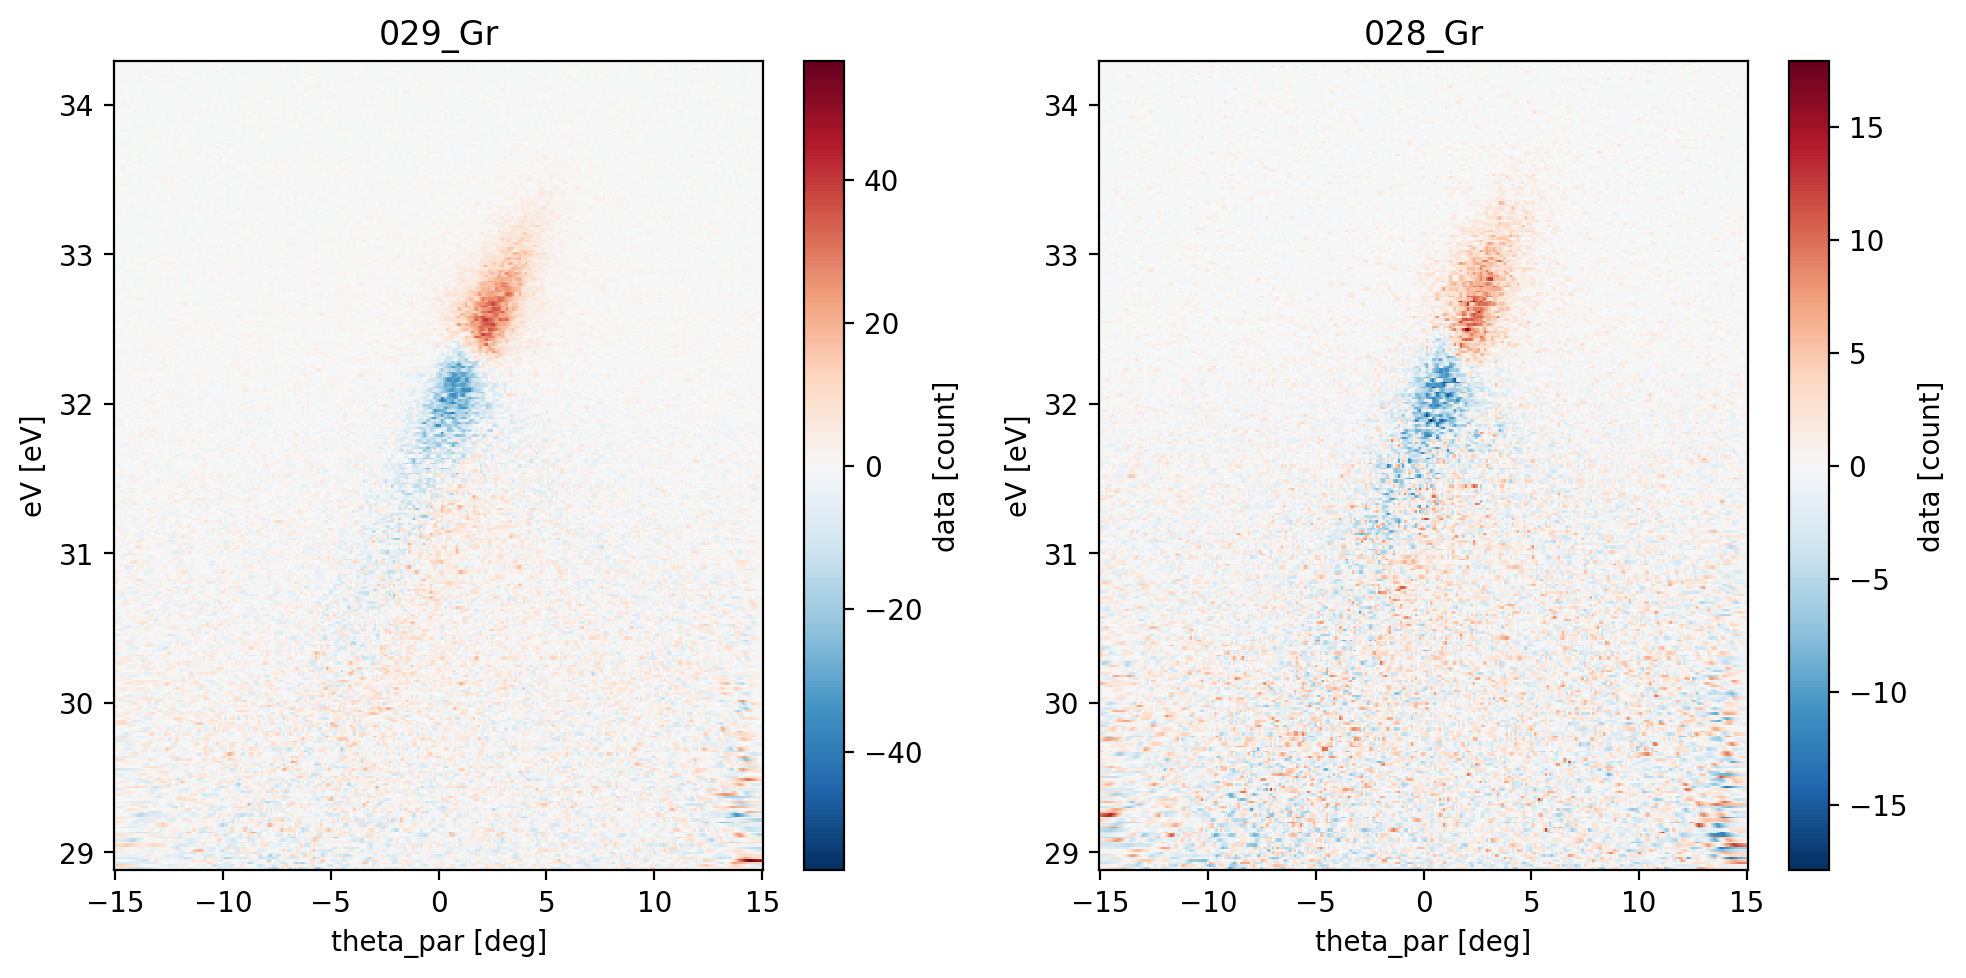

In [20]:
dt.tr.diff(200).plot_grid()